In [1]:
from astropy.io import fits
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('seaborn')
import datetime as dt
from astropy.stats import LombScargle

In [2]:
data_930 = pd.read_excel('../data/0930_measurements.xlsx')
data_1018a = pd.read_excel('../data/1018a_measurements.xlsx')
data_1018b = pd.read_excel('../data/1018b_measurements.xlsx')

In [3]:
mags_930 = data_930['Source_AMag_T1']
err_930 = data_930['Source_AMag_Err_T1']
filenames_930 = glob('../data/science/0930/processed/*.FIT')

mags_1018a = data_1018a['Source_AMag_T1']
err_1018a = data_1018a['Source_AMag_Err_T1']

mags_1018b = data_1018b['Source_AMag_T1']
err_1018b = data_1018b['Source_AMag_Err_T1']
filenames_1018 = glob('../data/science/1018/processed/*.FIT')

headers = [fits.getheader(file) for file in filenames_930]

for file in filenames_1018:
    headers.append(fits.getheader(file))
    
times = [hdr['DATE-OBS'] for hdr in headers]
fmt = '%Y-%m-%dT%H:%M:%S.%f'
times = [dt.datetime.strptime(time, fmt) for time in times]
time_since = []
for i, time in enumerate(times):
    time_since.append((time - times[0]).total_seconds() / 60)
    
mags = mags_930.append(mags_1018a).append(mags_1018b)
err = err_930.append(err_1018a).append(err_1018b)
    
t = np.array(time_since)

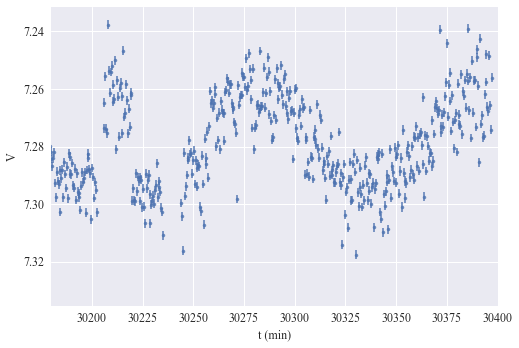

In [4]:
params = {
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'axes.labelsize':12,
    'legend.fontsize':8,
    'font.family':'Times New Roman',
    'font.weight':'normal'
}
matplotlib.rcParams.update(params)

plt.errorbar(t, mags, yerr=err, alpha=0.8,fmt='.')
plt.xlabel('t (min)')
plt.ylabel('V')
plt.xlim(30180, 30400)
plt.gca().invert_yaxis()

# plt.savefig('../docs/figs/mags.png')

0.00827379291173
120.863552021 0.0839330222369


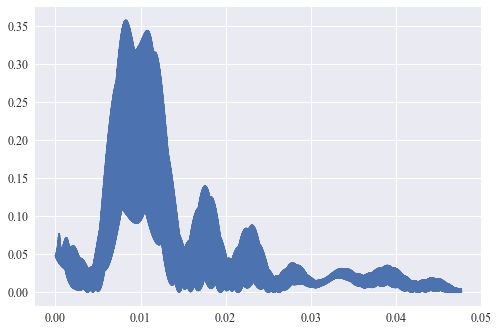

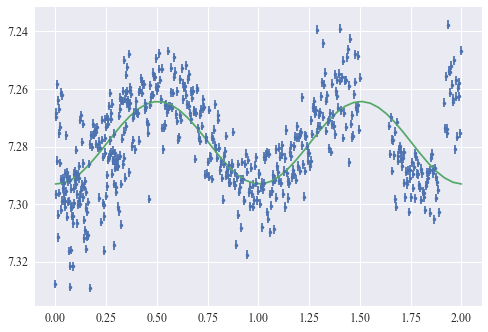

In [5]:
# frequency = np.linspace(1./100, 1./130, 100)
LS = LombScargle(t, mags, err, nterms=1)
frequency, power = LS.autopower()
plt.plot(frequency, power)
best_frequency = frequency[np.argmax(power)]

phase = (t * best_frequency) % 2

plt.figure()
plt.gca().invert_yaxis()
plt.errorbar(phase, mags, yerr=err, fmt='.')

phase_fit = np.linspace(0, 2)
y_fit = LS.model(phase_fit / best_frequency, best_frequency)
plt.plot(phase_fit, y_fit)

print(best_frequency)
print(1/best_frequency, 1/best_frequency/60/24)

Finding optimal frequency:
 - Estimated peak width = 0.000207
 - Using 5 steps per peak; omega_step = 4.13e-05
 - User-specified period range:  1e+02 to 1.5e+02
 - Computing periods at 508 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 122.81993494788814 min, 0.08529162149158899 d


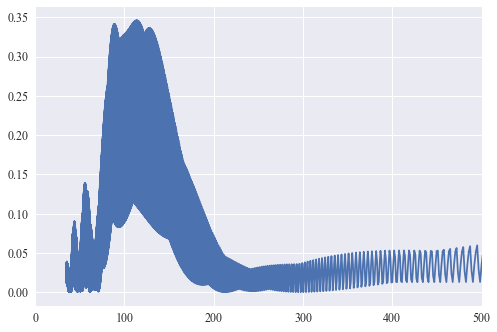

In [11]:
from gatspy.periodic import LombScargleFast
model = LombScargleFast().fit(t, mags, err)
periods, power = model.periodogram_auto()
plt.plot(periods, power)
plt.xlim(0, 500)

model.optimizer.period_range=(100, 150)
period = model.best_period
print("period = {0} min, {1} d".format(period, period / (60*24)))

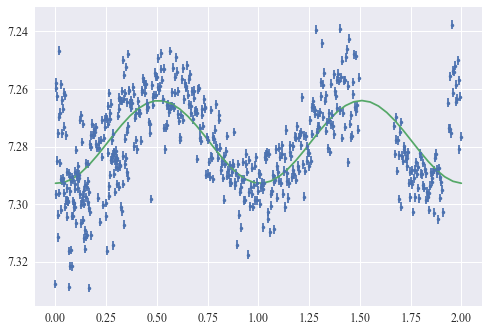

In [10]:
phase = (t / period) % 2

plt.figure()
plt.gca().invert_yaxis()
plt.errorbar(phase, mags, yerr=err, fmt='.')

phase_fit = np.linspace(0, 2)
y_fit = LS.model(phase_fit * period, 1/period)
plt.plot(phase_fit, y_fit)
